# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

In [56]:
import random
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value

    def __str__(self):
        return f"{self.rank} of {self.suit}"

class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.plastic_card_position = None
        self._create_deck()
        self.shuffle()

    def _create_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
        values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
                  'Jack': 10, 'Queen': 10, 'King': 10, 'Ace': 11}

        self.cards = [Card(suit, rank, values[rank]) for _ in range(self.num_decks)
                      for suit in suits for rank in ranks]

        self.plastic_card_position = random.randint(0, len(self.cards) - 1)

    def shuffle(self):
        random.shuffle(self.cards)
        print("Deck shuffled.")

    def draw(self):
        if len(self.cards) == 0:
            raise ValueError("The deck is empty. Cannot draw more cards.")

        card = self.cards.pop(0)

        if len(self.cards) == self.plastic_card_position:
            print("Plastic card reached! Reshuffling the deck...")
            self._create_deck()
            self.shuffle()

        return card

    def __len__(self):
        return len(self.cards)


In [59]:
class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def calculate_value(self):
        value = sum(card.value for card in self.cards)
        aces = sum(1 for card in self.cards if card.rank == 'Ace')

        while value > 21 and aces:
            value -= 10
            aces -= 1

        return value

    def is_busted(self):
        return self.calculate_value() > 21

    def __str__(self):
        return ', '.join(str(card) for card in self.cards)


class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.chips = chips
        self.hand = Hand()

    def place_bet(self, amount):
        if amount > self.chips:
            raise ValueError("Not enough chips to place this bet.")
        self.chips -= amount
        return amount

    def receive_card(self, card):
        self.hand.add_card(card)

    def clear_hand(self):
        self.hand = Hand()


class Dealer(Player):
    def __init__(self):
        super().__init__(name="Dealer")

    def should_hit(self):
        return self.hand.calculate_value() < 17


class Game:
    def __init__(self, num_decks=6):
        self.deck = Deck(num_decks)
        self.dealer = Dealer()
        self.human_player = Player(name="Human")

    def start_round(self):
        self.human_player.clear_hand()
        self.dealer.clear_hand()
        self.deal_initial_cards()
        self.player_turn(self.human_player)
        if not self.human_player.hand.is_busted():
            self.dealer_turn()

        self.determine_winner()

    def deal_initial_cards(self):
        for _ in range(2):
            self.human_player.receive_card(self.deck.draw())
            self.dealer.receive_card(self.deck.draw())

        print(f"Your hand: {self.human_player.hand} (Value: {self.human_player.hand.calculate_value()})")
        print(f"Dealer's visible card: {self.dealer.hand.cards[0]}")

    def player_turn(self, player):
        while True:
            print(f"Your hand: {player.hand} (Value: {player.hand.calculate_value()})")
            if player.hand.is_busted():
                print("You busted!")
                return

            action = input("Do you want to 'hit' or 'stand'? ").lower()
            if action == 'hit':
                player.receive_card(self.deck.draw())
            elif action == 'stand':
                break
            else:
                print("Invalid action. Please choose 'hit' or 'stand'.")

    def dealer_turn(self):
        print(f"Dealer's hand: {self.dealer.hand} (Value: {self.dealer.hand.calculate_value()})")
        while self.dealer.should_hit():
            print("Dealer hits.")
            self.dealer.receive_card(self.deck.draw())
            print(f"Dealer's hand: {self.dealer.hand} (Value: {self.dealer.hand.calculate_value()})")

        if self.dealer.hand.is_busted():
            print("Dealer busted!")

    def determine_winner(self):
        player_value = self.human_player.hand.calculate_value()
        dealer_value = self.dealer.hand.calculate_value()

        print(f"Your final hand: {self.human_player.hand} (Value: {player_value})")
        print(f"Dealer's final hand: {self.dealer.hand} (Value: {dealer_value})")

        if self.human_player.hand.is_busted():
            print("You lose!")
        elif self.dealer.hand.is_busted():
            print("You win!")
        elif player_value > dealer_value:
            print("You win!")
        elif player_value < dealer_value:
            print("You lose!")
        else:
            print("It's a tie!")

if __name__ == "__main__":
    # Create a game instance with 6 decks and 1 dealer
    game = Game(num_decks=6)

    print("Welcome to Blackjack!")
    print("You will play against the dealer. Try to beat the dealer without going over 21!")
    print("The dealer will hit on 16 and stand on 17 or higher.")

    # Play multiple rounds
    while True:
        # Start a new round
        game.start_round()

        # Ask the player if they want to play another round
        play_again = input("Do you want to play another round? (yes/no): ").lower()
        if play_again != 'yes':
            print("Thanks for playing! Goodbye!")
            break           

Deck shuffled.
Welcome to Blackjack!
You will play against the dealer. Try to beat the dealer without going over 21!
The dealer will hit on 16 and stand on 17 or higher.
Your hand: 2 of Hearts, Queen of Spades (Value: 12)
Dealer's visible card: 6 of Clubs
Your hand: 2 of Hearts, Queen of Spades (Value: 12)
Do you want to 'hit' or 'stand'? hit
Your hand: 2 of Hearts, Queen of Spades, Ace of Spades (Value: 13)
Do you want to 'hit' or 'stand'? hit
Your hand: 2 of Hearts, Queen of Spades, Ace of Spades, 4 of Diamonds (Value: 17)
Do you want to 'hit' or 'stand'? stand
Dealer's hand: 6 of Clubs, 6 of Clubs (Value: 12)
Dealer hits.
Dealer's hand: 6 of Clubs, 6 of Clubs, 8 of Spades (Value: 20)
Your final hand: 2 of Hearts, Queen of Spades, Ace of Spades, 4 of Diamonds (Value: 17)
Dealer's final hand: 6 of Clubs, 6 of Clubs, 8 of Spades (Value: 20)
You lose!
Do you want to play another round? (yes/no): yes
Your hand: Queen of Spades, King of Spades (Value: 20)
Dealer's visible card: Ace of Hea

In [60]:
class CountingPlayer(Player):
    def __init__(self, name, chips=1000, hit_threshold=-2):
        super().__init__(name, chips)
        self.running_count = 0 
        self.hit_threshold = hit_threshold

    def update_running_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.running_count += 1
        elif card.rank in ['10', 'Jack', 'Queen', 'King', 'Ace']:
            self.running_count -= 1

    def decide_action(self):
        if self.running_count <= self.hit_threshold:
            return 'hit'
        else:
            return 'stay'

    def play_turn(self, deck):
        while True:
            print(f"{self.name}'s hand: {self.hand} (Value: {self.hand.calculate_value()})")
            print(f"{self.name}'s running count: {self.running_count}")

            if self.hand.is_busted():
                print(f"{self.name} busted!")
                return

            action = self.decide_action()
            if action == 'hit':
                print(f"{self.name} decides to hit.")
                card = deck.draw()
                self.receive_card(card)
                self.update_running_count(card)
            else:
                print(f"{self.name} decides to stay.")
                break

In [61]:
class DealerStrategyPlayer(Player):
    def play_turn(self, deck):
        while self.hand.calculate_value() < 17:
            self.receive_card(deck.draw())


class Game:
    def __init__(self, num_decks=6, starting_chips=1000):
        self.deck = Deck(num_decks)
        self.strategy_player = CountingPlayer(name="Strategy Player", chips=starting_chips)
        self.dealer_strategy_players = [
            DealerStrategyPlayer(name=f"Dealer Strategy Player {i+1}", chips=starting_chips)
            for i in range(3)
        ]
        self.dealer = Dealer()
        self.starting_chips = starting_chips

    def play_round(self):
        self.strategy_player.clear_hand()
        for player in self.dealer_strategy_players:
            player.clear_hand()
        self.dealer.clear_hand()

        self.deal_initial_cards()
        self.strategy_player.play_turn(self.deck)

        for player in self.dealer_strategy_players:
            player.play_turn(self.deck)
        if not self.strategy_player.hand.is_busted() or any(
            not player.hand.is_busted() for player in self.dealer_strategy_players
        ):
            self.dealer_turn()

        self.determine_results()

    def deal_initial_cards(self):
        for _ in range(2):
            card = self.deck.draw()
            self.strategy_player.receive_card(card)
            self.strategy_player.update_running_count(card)

            for player in self.dealer_strategy_players:
                card = self.deck.draw()
                player.receive_card(card)
            card = self.deck.draw()
            self.dealer.receive_card(card)
            self.strategy_player.update_running_count(card)

    def dealer_turn(self):
        while self.dealer.should_hit():
            card = self.deck.draw()
            self.dealer.receive_card(card)
            self.strategy_player.update_running_count(card)

    def determine_results(self):
        dealer_value = self.dealer.hand.calculate_value()

        self.evaluate_player(self.strategy_player, dealer_value)

        for player in self.dealer_strategy_players:
            self.evaluate_player(player, dealer_value)

    def evaluate_player(self, player, dealer_value):
        player_value = player.hand.calculate_value()

        if player.hand.is_busted():
            pass
        elif self.dealer.hand.is_busted() or player_value > dealer_value:
            player.chips += 100  
        elif player_value < dealer_value:
            player.chips -= 100  
        else:
            pass

    def play_game(self, num_rounds=50, verbose=False):
        """
        Plays the game for a specified number of rounds or until the strategy player is out of money.
        :param num_rounds: The maximum number of rounds to play.
        :param verbose: Whether to print detailed output for each round.
        """
        for round_num in range(1, num_rounds + 1):
            if self.strategy_player.chips <= 0:
                if verbose:
                    print(f"Strategy Player is out of money after {round_num - 1} rounds.")
                break

            if verbose:
                print(f"--- Round {round_num} ---")
            self.play_round()

            if verbose:
                print(f"Strategy Player's chips: {self.strategy_player.chips}")
                for i, player in enumerate(self.dealer_strategy_players):
                    print(f"Dealer Strategy Player {i+1}'s chips: {player.chips}")
                print(f"Dealer's hand: {self.dealer.hand} (Value: {self.dealer.hand.calculate_value()})")
                print()

        print("Game Over!")
        print(f"Strategy Player's final chips: {self.strategy_player.chips}")
        for i, player in enumerate(self.dealer_strategy_players):
            print(f"Dealer Strategy Player {i+1}'s final chips: {player.chips}")


# Example usage
if __name__ == "__main__":
    game = Game(num_decks=6, starting_chips=1000)
    game.play_game(num_rounds=50, verbose=False)

Deck shuffled.
Strategy Player's hand: 7 of Clubs, 5 of Diamonds (Value: 12)
Strategy Player's running count: 1
Strategy Player decides to stay.
Strategy Player's hand: Queen of Spades, 3 of Clubs (Value: 13)
Strategy Player's running count: 0
Strategy Player decides to stay.
Strategy Player's hand: Queen of Diamonds, 10 of Clubs (Value: 20)
Strategy Player's running count: -5
Strategy Player decides to hit.
Strategy Player's hand: Queen of Diamonds, 10 of Clubs, 2 of Spades (Value: 22)
Strategy Player's running count: -4
Strategy Player busted!
Strategy Player's hand: Ace of Hearts, 2 of Diamonds (Value: 13)
Strategy Player's running count: -2
Strategy Player decides to hit.
Plastic card reached! Reshuffling the deck...
Deck shuffled.
Strategy Player's hand: Ace of Hearts, 2 of Diamonds, 7 of Spades (Value: 20)
Strategy Player's running count: -2
Strategy Player decides to hit.
Strategy Player's hand: Ace of Hearts, 2 of Diamonds, 7 of Spades, 10 of Clubs (Value: 20)
Strategy Player's

Deck shuffled.
Strategy Player's hand: Queen of Spades, 9 of Hearts (Value: 19)
Strategy Player's running count: -1
Strategy Player decides to stay.
Strategy Player's hand: King of Spades, 6 of Clubs (Value: 16)
Strategy Player's running count: -2
Strategy Player decides to hit.
Strategy Player's hand: King of Spades, 6 of Clubs, 5 of Clubs (Value: 21)
Strategy Player's running count: -1
Strategy Player decides to stay.
Plastic card reached! Reshuffling the deck...
Deck shuffled.
Strategy Player's hand: Ace of Diamonds, 3 of Clubs (Value: 14)
Strategy Player's running count: 0
Strategy Player decides to stay.
Strategy Player's hand: 6 of Diamonds, 4 of Diamonds (Value: 10)
Strategy Player's running count: 2
Strategy Player decides to stay.
Strategy Player's hand: 9 of Diamonds, 10 of Clubs (Value: 19)
Strategy Player's running count: 2
Strategy Player decides to stay.
Strategy Player's hand: 6 of Spades, King of Hearts (Value: 16)
Strategy Player's running count: -1
Strategy Player dec

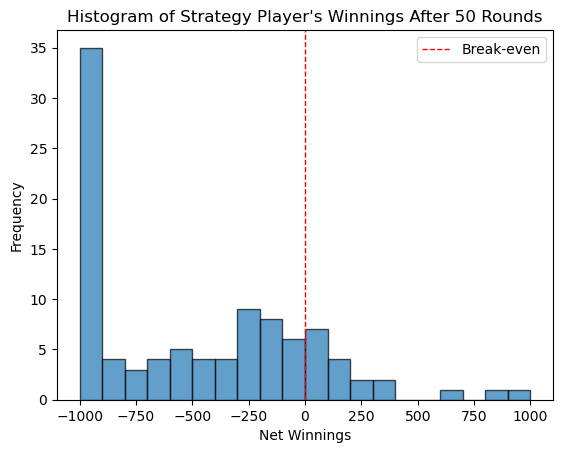

In [62]:
import matplotlib.pyplot as plt
import numpy as np
def simulate_games(num_games=100, num_rounds=50, starting_chips=1000):
    winnings = [] 

    for _ in range(num_games):
        game = Game(num_decks=6, starting_chips=starting_chips)
        game.play_game(num_rounds=num_rounds, verbose=False)
        winnings.append(game.strategy_player.chips - starting_chips)
    return winnings

num_games = 100
num_rounds = 50
starting_chips = 1000
winnings = simulate_games(num_games=num_games, num_rounds=num_rounds, starting_chips=starting_chips)

average_winnings_per_round = np.mean(winnings) / num_rounds
std_dev = np.std(winnings)
probability_of_net_winning = np.sum(np.array(winnings) > 0) / num_games
probability_of_net_losing = np.sum(np.array(winnings) < 0) / num_games
print(f"Average winnings per round: {average_winnings_per_round:.2f}")
print(f"Standard deviation of winnings: {std_dev:.2f}")
print(f"Probability of net winning after 50 rounds: {probability_of_net_winning:.2f}")
print(f"Probability of net losing after 50 rounds: {probability_of_net_losing:.2f}")

plt.hist(winnings, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Strategy Player's Winnings After 50 Rounds")
plt.xlabel("Net Winnings")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label="Break-even")
plt.legend()
plt.show()

Simulating for threshold: -4
Deck shuffled.
Strategy Player's hand: 8 of Clubs, 5 of Hearts (Value: 13)
Strategy Player's running count: -1
Strategy Player decides to stay.
Plastic card reached! Reshuffling the deck...
Deck shuffled.
Strategy Player's hand: 3 of Hearts, 7 of Spades (Value: 10)
Strategy Player's running count: 2
Strategy Player decides to stay.
Strategy Player's hand: 10 of Clubs, 6 of Clubs (Value: 16)
Strategy Player's running count: 1
Strategy Player decides to stay.
Strategy Player's hand: 9 of Diamonds, 9 of Spades (Value: 18)
Strategy Player's running count: 1
Strategy Player decides to stay.
Strategy Player's hand: 9 of Clubs, 4 of Diamonds (Value: 13)
Strategy Player's running count: 6
Strategy Player decides to stay.
Strategy Player's hand: Queen of Spades, King of Clubs (Value: 20)
Strategy Player's running count: 7
Strategy Player decides to stay.
Strategy Player's hand: 10 of Spades, Jack of Spades (Value: 20)
Strategy Player's running count: 8
Strategy Play

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



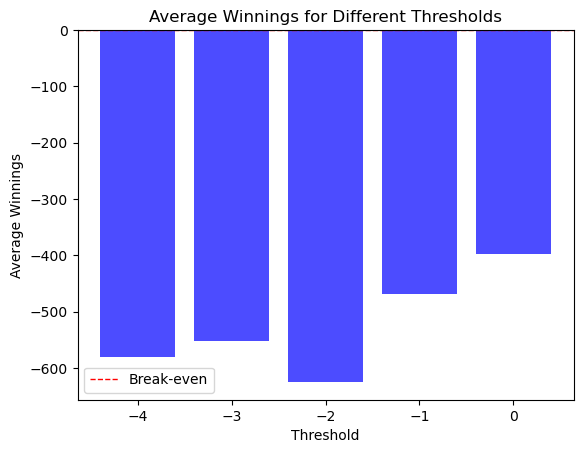

In [63]:
def simulate_thresholds(threshold_values, num_games=100, num_rounds=50, starting_chips=1000):
    results = {}

    for threshold in threshold_values:
        print(f"Simulating for threshold: {threshold}")
        winnings = [] 

        for _ in range(num_games):
            game = Game(num_decks=6, starting_chips=starting_chips)
            game.strategy_player = CountingPlayer(name="Strategy Player", chips=starting_chips, hit_threshold=threshold)
            game.play_game(num_rounds=num_rounds, verbose=False)
            winnings.append(game.strategy_player.chips - starting_chips)
        avg_winnings = np.mean(winnings)
        std_dev = np.std(winnings)
        prob_net_winning = np.sum(np.array(winnings) > 0) / num_games
        prob_net_losing = np.sum(np.array(winnings) < 0) / num_games
        results[threshold] = {
            "average_winnings": avg_winnings,
            "std_dev": std_dev,
            "prob_net_winning": prob_net_winning,
            "prob_net_losing": prob_net_losing,
        }

    return results

threshold_values = [-4, -3, -2, -1, 0]
results = simulate_thresholds(threshold_values)
print("\nResults:")
for threshold, stats in results.items():
    print(f"Threshold: {threshold}")
    print(f"  Average Winnings: {stats['average_winnings']:.2f}")
    print(f"  Standard Deviation: {stats['std_dev']:.2f}")
    print(f"  Probability of Net Winning: {stats['prob_net_winning']:.2f}")
    print(f"  Probability of Net Losing: {stats['prob_net_losing']:.2f}")
    print()
thresholds = list(results.keys())
avg_winnings = [results[t]["average_winnings"] for t in thresholds]

plt.bar(thresholds, avg_winnings, color='blue', alpha=0.7)
plt.title("Average Winnings for Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Average Winnings")
plt.axhline(0, color='red', linestyle='dashed', linewidth=1, label="Break-even")
plt.legend()
plt.show()